In [669]:
import pandas as pd
import numpy as np
import seaborn as sns
# from backtest import executer
import matplotlib.pyplot as plt
import plotly.express as px
import math
import ast

In [670]:
# MAKE BACKTEST

# dfs = executer(n_workers=6)

# df_list = [pd.DataFrame(d) for d in dfs]
# df = pd.concat(df_list)
# df.head()

In [671]:
portfolio = pd.read_excel('PORTFOLIO.xlsx')

df = pd.read_csv('backtest_correct.csv')
df['date'] = pd.to_datetime(df.date)

df['stock1'] = [pair.split("'")[1] for pair in df.pair]

In [672]:
df = df.merge(portfolio.drop_duplicates('ticker'), left_on='stock1', right_on='ticker',how='left')

In [673]:
df.drop(columns=['stock1', 'ticker'], inplace=True)

In [674]:
df['pair'] = df.pair.apply(ast.literal_eval)

In [675]:
df['sorted_pair'] = df.pair.apply(sorted).apply(tuple)

In [676]:
df['sorted_pair'].value_counts()

(EQTL3, TAEE11)     213
(ELET3, ELET6)      160
(PETR3, PETR4)      157
(FLRY3, QUAL3)      121
(BBAS3, BBSE3)      117
                   ... 
(CCRO3, WEGE3)        3
(RRRP3, UGPA3)        2
(BBAS3, SULA11)       2
(BPAC11, SANB11)      2
(CPLE6, EGIE3)        2
Name: sorted_pair, Length: 202, dtype: int64

In [677]:
df.drop_duplicates(subset=['date', 'sorted_pair'], keep='first',inplace=True)

In [678]:
df.loc[(df.duplicated(subset=['date', 'sorted_pair'], keep='first'))].sort_values(by=['date', 'sorted_pair'])

,date,pair,status,price_fst_stock,price_scnd_stock,beta_open,beta_close,last_residual,std_residual,std_open_residual,...,open_price_scnd_stock,open_date,close_limit,stop_limit,halflife,days_open,data_ini,data_fin,setor,sorted_pair


In [679]:
def result_calculator(row):
    
    
    long_result = row['price_fst_stock'] - row['open_price_first_stock']
    short_result = row['open_price_scnd_stock'] - row['price_scnd_stock']
    
#     long_result = row['open_price_first_stock'] - row['price_fst_stock']
#     short_result = row['price_scnd_stock'] - row['open_price_scnd_stock']

    result = long_result + short_result
    
    if row['residual_open'] > row['std_open_residual']:
        result = - result

    return result 

In [680]:
cond = (df.status.isin(['True', 'close']))

In [681]:
df.loc[cond, 'result'] = df.loc[cond].apply(lambda row: result_calculator(row), axis=1)

In [716]:
df.loc[(df.status=='True') & (df.date=='2022-06-09')].result_beta_neutral.sum()

6.773605426905628

In [717]:
# Cash Neutral

# quant1 = df.loc[cond, 'open_price_first_stock'] / (df.loc[cond, 'open_price_scnd_stock'] + df.loc[cond, 'open_price_first_stock'])
# quant2 = 1-quant1

quant2 = df.loc[cond].open_price_first_stock / df.loc[cond].open_price_scnd_stock
quant1 = 1

# df.loc[cond,'quant1'] = quant1
# df.loc[cond,'quant2'] = quant2

long_result = df.loc[cond,'price_fst_stock'] - df.loc[cond,'open_price_first_stock']
short_result = df.loc[cond,'open_price_scnd_stock'] - df.loc[cond,'price_scnd_stock']

result = (quant1 * long_result) + (short_result * quant2)

df.loc[cond,'cash'] = (quant1 * df.loc[cond, 'open_price_first_stock']) + (quant2 * df.loc[cond, 'open_price_scnd_stock'])

df.loc[cond, 'result_cash_neutral'] = result
df.loc[(cond) & (df.residual_open > df.std_open_residual), 'result_cash_neutral'] = - result


In [684]:
# Beta Neutral

# quant1 = df.loc[cond, 'open_price_first_stock'] / (df.loc[cond, 'open_price_scnd_stock'] + df.loc[cond, 'open_price_first_stock'])
# quant2 = 1-quant1

quant2 = df.loc[cond].beta_open
quant1 = 1

# df.loc[cond,'quant1'] = quant1
# df.loc[cond,'quant2'] = quant2

result = (quant1) * (df.loc[cond, 'price_fst_stock'] - df.loc[cond, 'open_price_first_stock']) + (df.loc[cond, 'open_price_scnd_stock'] - df.loc[cond,'price_scnd_stock']) * (quant2)

df.loc[cond,'cash'] = (quant1 * df.loc[cond, 'open_price_first_stock']) + (quant2 * df.loc[cond, 'open_price_scnd_stock'])

df.loc[cond, 'result_beta_neutral'] = result
df.loc[(cond) & (df.residual_open > df.std_open_residual), 'result_beta_neutral'] = - result

In [723]:
df.loc[df.status=='close'][['result', 'result_cash_neutral', 'result_beta_neutral']].sum()

result                 141.110000
result_cash_neutral    158.749378
result_beta_neutral     76.747159
dtype: float64

In [687]:
closed = df.loc[df.status=='close'].copy()

closed['is_profit'] = closed['result'] > 0
closed['is_profit_CN'] = closed['result_cash_neutral'] > 0
closed['is_profit_BN'] = closed['result_beta_neutral'] > 0


In [688]:
# closed = closed.loc[closed.halflife.between(0,10)]

In [724]:
closed.loc[closed.halflife.between(0,15)].set_index('date').resample('6M')[['is_profit', 'is_profit_CN', 'is_profit_BN']].mean()

,is_profit,is_profit_CN,is_profit_BN
date,,,
2019-07-31,0.526316,0.631579,0.578947
2020-01-31,0.495798,0.512605,0.512605
2020-07-31,0.472050,0.490683,0.397516
2021-01-31,0.495798,0.537815,0.546218
2021-07-31,0.481752,0.518248,0.489051
2022-01-31,0.571429,0.540816,0.489796
2022-07-31,0.542857,0.521429,0.492857


[]

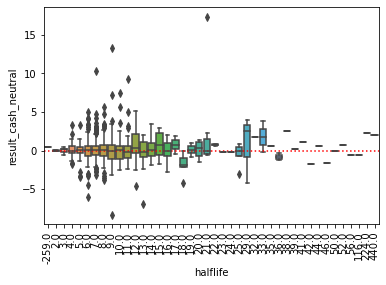

In [715]:
sns.boxplot(x=closed.halflife, y=closed.result_cash_neutral)
plt.axhline(y=0, linestyle='dotted', color='red')
plt.xticks(rotation=90)
plt.plot()

In [690]:
closed

,date,pair,status,price_fst_stock,price_scnd_stock,beta_open,beta_close,last_residual,std_residual,std_open_residual,...,data_fin,setor,sorted_pair,result,cash,result_cash_neutral,result_beta_neutral,is_profit,is_profit_CN,is_profit_BN
6,2019-07-12,"(AZUL4, GOLL4)",close,49.09,39.25,0.985577,0.959254,-0.997707,1.312356,1.262734,...,2019-12-31,Aéreas,"(AZUL4, GOLL4)",1.25,79.216987,0.361296,1.303075,True,True,True
8,2019-08-08,"(AZUL4, GOLL4)",close,54.55,40.13,0.947513,0.949865,3.622113,1.271835,1.258947,...,2019-12-31,Aéreas,"(AZUL4, GOLL4)",-0.94,90.679407,-0.773370,-0.965719,False,False,False
10,2019-08-12,"(AZUL4, GOLL4)",close,54.30,37.78,0.952723,0.956020,5.464358,1.330845,1.290817,...,2019-12-31,Aéreas,"(AZUL4, GOLL4)",-1.76,94.255342,-2.822314,-1.621478,False,False,False
14,2019-08-16,"(AZUL4, GOLL4)",close,50.47,35.11,0.958335,0.962279,4.025377,1.390943,1.351507,...,2019-12-31,Aéreas,"(AZUL4, GOLL4)",-0.05,90.196745,-1.303146,0.080410,False,False,True
17,2019-08-21,"(AZUL4, GOLL4)",close,50.85,35.31,0.963053,0.965595,4.115253,1.430462,1.400806,...,2019-12-31,Aéreas,"(AZUL4, GOLL4)",-0.74,83.565764,-0.621701,-0.750345,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8061,2022-03-28,"(LREN3, PCAR3)",close,26.76,24.30,0.838914,0.885712,-2.273566,2.287782,2.576742,...,2019-12-31,Varejo,"(LREN3, PCAR3)",2.52,40.616781,2.525913,2.871167,True,True,True
8072,2022-05-23,"(PETZ3, ALPA4)",close,12.29,20.76,0.286549,0.295960,-2.526468,1.618112,1.575374,...,2022-07-01,Varejo,"(ALPA4, PETZ3)",0.68,17.790331,0.601347,0.551579,True,True,True
8085,2022-02-16,"(SOMA3, ALPA4)",close,13.28,27.09,0.213015,0.196235,1.604310,1.294916,1.245217,...,2022-07-01,Varejo,"(ALPA4, SOMA3)",-0.88,20.584487,0.125265,0.686099,False,True,True
8100,2022-04-26,"(VIIA3, CVCB3)",close,3.04,13.10,0.773178,0.782418,-0.954175,1.405617,1.518323,...,2019-12-31,Varejo,"(CVCB3, VIIA3)",2.73,17.442680,-0.233079,1.834052,True,False,True


In [691]:
closed_daily = closed.groupby('date').agg({'result':sum, 'result_cash_neutral':sum,'result_beta_neutral':sum})

In [718]:
opens_by_date = df.loc[df.status=='True'].groupby('date').sum()
opens_by_date.cash.describe()

count     744.000000
mean      355.479704
std       242.097704
min         7.740000
25%       183.480000
50%       294.510000
75%       449.940000
max      1323.120000
Name: cash, dtype: float64

In [725]:
print('resultado:', closed.result.sum())
print('acerto:', closed.is_profit.mean())
print('-'*30)
print('resultado cash neutral:', closed.result_cash_neutral.sum())
print('acerto cash neutral:', closed.is_profit_CN.mean())
print('-'*30)
print('resultado beta neutral:', closed.result_beta_neutral.sum())
print('acerto beta neutral:', closed.is_profit_BN.mean())

resultado: 141.10999999999999
acerto: 0.5117096018735363
------------------------------
resultado cash neutral: 158.74937776597042
acerto cash neutral: 0.5175644028103045
------------------------------
resultado beta neutral: 76.74715889777562
acerto beta neutral: 0.47540983606557374


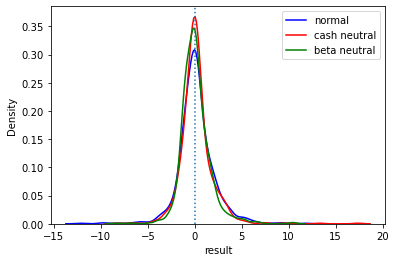

In [694]:
sns.kdeplot(x=closed.result, color='blue', label='normal')
sns.kdeplot(x=closed.result_cash_neutral, color='red', label='cash neutral')
sns.kdeplot(x=closed.result_beta_neutral, color='green', label='beta neutral')

plt.axvline(x=0, linestyle='dotted')
plt.legend()
plt.show()

In [662]:
print(closed.loc[closed.is_profit].result.mean())
print(closed.loc[closed.is_profit_CN].result_cash_neutral.mean())
print(closed.loc[closed.is_profit_BN].result_beta_neutral.mean())

print(closed.loc[~closed.is_profit].result.mean())
print(closed.loc[~closed.is_profit_CN].result_cash_neutral.mean())
print(closed.loc[~closed.is_profit_BN].result_beta_neutral.mean())

1.257083333333333
0.966157492360017
0.9676699114495265
-0.9686956521739133
-0.9124980438459966
-0.8694613825029133


In [695]:
closed.loc[closed.result_cash_neutral.idxmax()]

date                      2020-03-27 00:00:00
pair                           (AMER3, MGLU3)
status                                  close
price_fst_stock                         49.99
price_scnd_stock                         9.72
beta_open                            4.181987
beta_close                           4.339482
last_residual                        0.702329
std_residual                         4.326128
std_open_residual                     4.78419
residual_open                       10.906997
open_price_first_stock                  49.72
open_price_scnd_stock                    7.18
open_date                          2020-03-18
close_limit                          2.392095
stop_limit                          10.568379
halflife                                 21.0
days_open                                   7
data_ini                  2019-07-01 00:00:00
data_fin                  2019-12-31 00:00:00
setor                                  Varejo
sorted_pair                    (AM

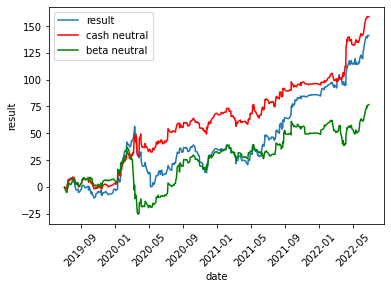

In [696]:
sns.lineplot(x=closed_daily.index, y=closed_daily.result.cumsum(), label='result')
sns.lineplot(x=closed_daily.index, y=closed_daily.result_cash_neutral.cumsum(),color='red', label='cash neutral')
sns.lineplot(x=closed_daily.index, y=closed_daily.result_beta_neutral.cumsum(),color='green', label='beta neutral')


plt.xticks(rotation=45)
plt.show()

In [697]:
closed_by_sector = closed.groupby('setor').agg(
    result = ('result', 'sum'),
    result_mean = ('result', 'mean'),
    result_CN = ('result_cash_neutral', 'sum'),
    result_mean_CN = ('result_cash_neutral', 'mean'),
    count = ('result', 'count'),
    accuracy = ('is_profit', 'mean'),
    accuracy_CN = ('is_profit_CN', 'mean')
)

closed_by_sector.sort_values(by='accuracy', ascending=False)

,result,result_mean,result_CN,result_mean_CN,count,accuracy,accuracy_CN
setor,,,,,,,
Papel e Celulose,13.58,1.697500,11.138090,1.392261,8,0.875000,1.000000
Bens Industriais,13.87,0.396286,17.538636,0.501104,35,0.628571,0.628571
Exploração de imóveis,0.69,0.098571,3.912642,0.558949,7,0.571429,0.571429
Saúde,35.81,0.587049,33.563813,0.550226,61,0.557377,0.557377
Construção Civil,-1.58,-0.175556,-3.134821,-0.348313,9,0.555556,0.555556
Financeiro,69.96,0.277619,48.193797,0.191245,252,0.535714,0.523810
Alimentos e Bebidas,7.15,0.223437,2.003194,0.062600,32,0.500000,0.531250
Educação,3.69,0.922500,0.907112,0.226778,4,0.500000,0.500000
Mineração e Siderurgia,4.45,0.087255,9.174532,0.179893,51,0.490196,0.431373


In [698]:
closed_by_sector = closed.groupby('setor').agg(
    result = ('result', 'sum'),
    result_mean = ('result', 'mean'),
    result_CN = ('result_cash_neutral', 'sum'),
    result_mean_CN = ('result_cash_neutral', 'mean'),
    count = ('result', 'count'),
    accuracy = ('is_profit', 'mean'),
    accuracy_CN = ('is_profit_CN', 'mean')
)

closed_by_sector.sort_values(by='accuracy', ascending=False)

,result,result_mean,result_CN,result_mean_CN,count,accuracy,accuracy_CN
setor,,,,,,,
Papel e Celulose,13.58,1.697500,11.138090,1.392261,8,0.875000,1.000000
Bens Industriais,13.87,0.396286,17.538636,0.501104,35,0.628571,0.628571
Exploração de imóveis,0.69,0.098571,3.912642,0.558949,7,0.571429,0.571429
Saúde,35.81,0.587049,33.563813,0.550226,61,0.557377,0.557377
Construção Civil,-1.58,-0.175556,-3.134821,-0.348313,9,0.555556,0.555556
Financeiro,69.96,0.277619,48.193797,0.191245,252,0.535714,0.523810
Alimentos e Bebidas,7.15,0.223437,2.003194,0.062600,32,0.500000,0.531250
Educação,3.69,0.922500,0.907112,0.226778,4,0.500000,0.500000
Mineração e Siderurgia,4.45,0.087255,9.174532,0.179893,51,0.490196,0.431373


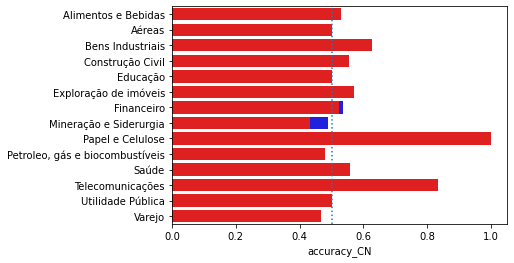

In [699]:
sns.barplot(y=closed_by_sector.index, x=closed_by_sector.accuracy, orient='h', color='blue')
sns.barplot(y=closed_by_sector.index, x=closed_by_sector.accuracy_CN, orient='h', color='red')
plt.axvline(x=0.5, linestyle='dotted')

plt.ylabel(None)
plt.show()

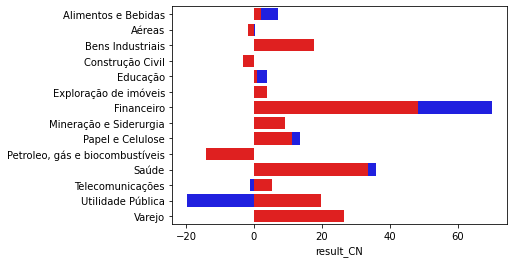

In [700]:
sns.barplot(y=closed_by_sector.index, x=closed_by_sector.result, orient='h', color='blue')
sns.barplot(y=closed_by_sector.index, x=closed_by_sector.result_CN, orient='h', color='red')

plt.ylabel(None)
plt.show()

In [726]:
pair_closed = closed.groupby('sorted_pair').agg(
    result_sum=('result', 'sum'),
    result_mean=('result', 'mean'),
    result_sum_CN=('result_cash_neutral', 'sum'),
    result_mean_CN=('result_cash_neutral', 'mean'),
    count=('result', 'count'),
    accuracy=('is_profit', 'mean'),
    accuracy_CN=('is_profit_CN', 'mean'),
    sector=('setor', 'last')
    )

pair_closed.loc[pair_closed['count']>3].sort_values(by=['accuracy_CN', 'count'], ascending=False).head(25)

,result_sum,result_mean,result_sum_CN,result_mean_CN,count,accuracy,accuracy_CN,sector
sorted_pair,,,,,,,,
"(KLBN11, SUZB3)",13.58,1.697500,11.138090,1.392261,8,0.875000,1.000000,Papel e Celulose
"(ITUB4, SULA11)",16.57,4.142500,8.355484,2.088871,4,1.000000,1.000000,Financeiro
"(BBDC3, BBDC4)",0.83,0.092222,1.356925,0.150769,9,0.666667,0.888889,Financeiro
"(TIMS3, VIVT3)",-1.22,-0.203333,5.229974,0.871662,6,0.333333,0.833333,Telecomunicações
"(CCRO3, RAIL3)",7.56,0.687273,10.609024,0.964457,11,0.818182,0.818182,Bens Industriais
"(HAPV3, RADL3)",5.45,1.090000,6.652268,1.330454,5,0.800000,0.800000,Saúde
"(LREN3, VIIA3)",9.49,1.898000,9.642385,1.928477,5,0.800000,0.800000,Varejo
"(BBAS3, BBSE3)",10.19,1.132222,11.033318,1.225924,9,0.777778,0.777778,Financeiro
"(ABEV3, JBSS3)",1.48,0.370000,-0.685357,-0.171339,4,0.500000,0.750000,Alimentos e Bebidas


In [55]:
# pair_closed.to_excel('pares_parcial.xlsx')

In [56]:
bd = pd.read_excel("BD COMPLETO.xlsx")
bd.dropna(inplace=True)
bd.set_index('Data', inplace=True)

In [240]:
bd['log_ret'] = np.log(bd['BOVA11']/ bd['BOVA11'].shift())
bd

,ARZZ3,AZUL4,B3SA3,BBAS3,BBDC3,BBDC4,BBSE3,BEEF3,BOVA11,BRAP4,...,TAEE11,TIET11,VVAR3,YDUQ3,NTCO3,ITSA4,BPAC11,BOVV11,dol,log_ret
Data,,,,,,,,,,,,,,,,,,,,,
2017-04-11,28.5749,22.40,17.4028,28.1720,17.3703,17.6168,21.0011,9.78,62.42,17.2488,...,16.4007,10.4669,3.9803,14.2525,14.7845,6.8240,15.8492,64.46,3.531422,NaN
2017-04-12,28.5031,22.96,17.3301,27.7085,17.2553,17.4412,20.7890,9.87,61.68,16.2195,...,16.5075,10.3283,4.2291,14.5797,14.7213,6.7885,16.1625,64.00,3.519090,-0.011926
2017-04-13,28.7992,22.99,16.8300,26.2664,16.7844,16.9090,20.5403,9.95,60.80,16.3053,...,16.2939,10.3822,4.2291,13.9166,14.5948,6.6179,15.5868,62.93,3.536467,-0.014370
2017-04-17,28.6646,22.85,17.7756,27.4853,17.4415,17.6662,21.2791,10.00,62.25,16.5540,...,16.3865,10.4515,4.1793,14.7654,15.0277,6.7956,15.5783,64.44,3.483776,0.023569
2017-04-18,28.2609,23.91,17.9120,27.7514,17.4470,17.5619,21.2060,9.95,61.95,16.1166,...,16.5929,10.3052,4.3684,14.6769,14.9061,6.8525,15.2397,64.20,3.492744,-0.004831
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-09-10,56.9600,26.10,56.0000,32.4254,19.3100,20.8500,26.2800,12.93,95.04,43.0300,...,28.7300,14.9000,18.0200,27.3100,49.7500,9.4600,79.1300,99.20,5.325000,-0.025555
2020-09-11,55.7500,26.58,56.0200,31.8971,18.8700,20.4600,25.4700,12.93,94.48,44.9000,...,28.3800,14.6500,17.9600,27.8900,51.6200,9.2700,78.1100,98.60,5.320500,-0.005910
2020-09-14,57.1700,28.25,58.7300,32.3600,19.1600,20.7000,25.8600,13.27,96.51,44.5500,...,28.6000,14.7700,18.3700,30.1100,53.2600,9.3800,81.4800,100.72,5.273000,0.021258


In [241]:
gpd = df.loc[df.status=='close'].groupby('date').sum().cumsum()
gpd.index = pd.to_datetime(gpd.index)

In [242]:
log_ret = bd.log_ret.rolling(103).std() * math.sqrt(252) * 100
bd['log_ret'] = log_ret
dd = gpd.join(bd, how='left')

In [243]:
dd.tail()

,Unnamed: 0,price_fst_stock,price_scnd_stock,beta,last_residual,std_residual,std_open_residual,residual_open,open_price_first_stock,open_price_scnd_stock,...,TAEE11,TIET11,VVAR3,YDUQ3,NTCO3,ITSA4,BPAC11,BOVV11,dol,log_ret
date,,,,,,,,,,,,,,,,,,,,,
2020-09-09,2023459,153315.2398,133838.780443,4598.712571,2438.870269,6027.001567,5508.004742,1587.831755,152065.9483,132933.602791,...,29.24,15.00,18.51,27.99,50.72,9.68,81.51,101.84,5.3125,27.819332
2020-09-10,2027911,153530.0298,134065.620443,4605.470703,2458.813394,6034.175484,5514.794709,1602.400746,152279.9083,133165.022891,...,28.73,14.90,18.02,27.31,49.75,9.46,79.13,99.20,5.3250,28.121526
2020-09-11,2033112,153700.4498,134203.500443,4609.935487,2463.226779,6040.043439,5520.014270,1607.310900,152451.1851,133304.013891,...,28.38,14.65,17.96,27.89,51.62,9.27,78.11,98.60,5.3205,28.080393
2020-09-14,2040552,154000.0398,134422.380443,4624.645357,2465.772731,6053.392315,5532.372547,1607.244930,152748.8051,133528.386891,...,28.60,14.77,18.37,30.11,53.26,9.38,81.48,100.72,5.2730,28.109877
2020-09-15,2045767,154226.1198,134554.700443,4643.035102,2468.318826,6064.113085,5542.253587,1601.723373,152973.6151,133665.316891,...,28.56,14.76,18.55,29.70,53.50,9.26,79.89,100.64,5.2780,28.052406


In [244]:
dd[['result', 'log_ret']].corr()

,result,log_ret
result,1.000000,0.723979
log_ret,0.723979,1.000000


In [245]:
px.line(dd[['result', 'log_ret']])

In [203]:
px.line(x=result_sum.index, y=result_sum.profit_loss)


In [196]:
bd.log_ret['2019'].std() * math.sqrt(252)

0.18208665089545323

In [193]:
(bd['BOVA11'] / bd['BOVA11'].shift()).std() * math.sqrt(252)

0.2925416460702591

In [179]:
bd['BOVA11'].pct_change()

Data
2017-04-11         NaN
2017-04-12   -0.011855
2017-04-13   -0.014267
2017-04-17    0.023849
2017-04-18   -0.004819
                ...   
2020-09-10   -0.025231
2020-09-11   -0.005892
2020-09-14    0.021486
2020-09-15   -0.000518
2020-09-16   -0.005702
Name: BOVA11, Length: 849, dtype: float64

In [ ]:
# Volatility
bd['log_ret'] = np.log(bd['BOVA11']/ bd['BOVA11'].shift())
anualized_vol = bd.log_ret.rolling(103).std() * math.sqrt(252) * 100
